In this notebook we will see the basics of how to use MiniSom.

Let's start importing MiniSom:

In [1]:
from minisom import MiniSom

MiniSom relies on the Python ecosystem to import and preprocess the data. For this example we will load the <a href="https://archive.ics.uci.edu/ml/datasets/seeds">seeds</a> dataset dataset using pandas:

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
                    names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                   'asymmetry_coefficient', 'length_kernel_groove', 'target'], 
                   sep='\t+', engine='python')
target = data['target'].values
label_names = {1:'Kama', 2:'Rosa', 3:'Canadian'}
data = data[data.columns[:-1]]
# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

We can initialize and train MiniSom as follows:

In [3]:
# Initialization and training
n_neurons = 9
m_neurons = 9
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=1.5, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0)

som.pca_weights_init(data)
som.train(data, 1000, verbose=True)  # random training

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.6426435848319221


To visualize the result of the training we can plot the distance map (U-Matrix) using a pseudocolor where the neurons of the maps are displayed as an array of cells and the color represents the (weights) distance from the neighbour neurons. On top of the pseudo color we can add markers that repesent the samples mapped in the specific cells:

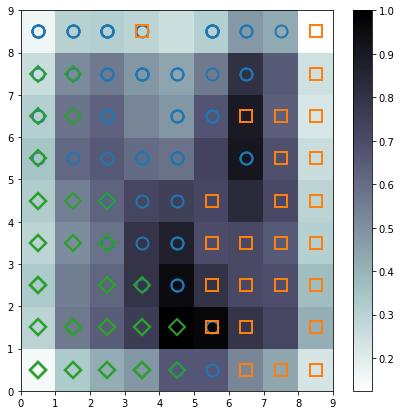

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(7, 7))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2']
for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[target[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

To have an overview of how the samples are distributed across the map a scatter chart can be used where each dot represents the coordinates of the winning neuron. A random offset is added to avoid overlaps between points within the same cell.

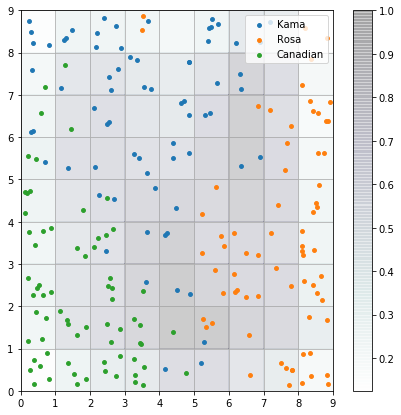

In [8]:
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(7, 7))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=15, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.savefig('resulting_images/som_seed.png')
plt.show()

To have an idea of which neurons of the map are activated more often we can create another pseudocolor plot that reflects the activation frequencies:

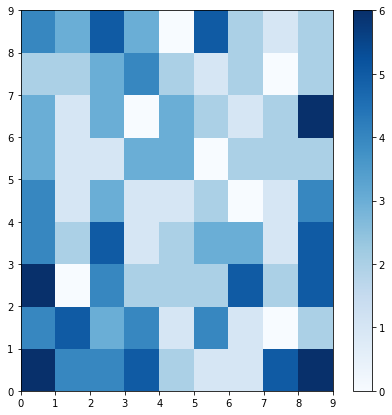

In [21]:
plt.figure(figsize=(7, 7))
frequencies = som.activation_response(data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

Wehn dealing with a supervised problem, one can visualize the proportion of samples per class falling in a specific neuron using a pie chart per neuron:

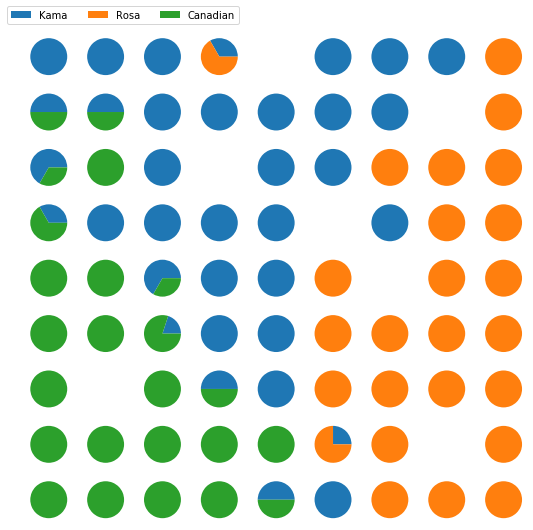

In [22]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(data, [label_names[t] for t in target])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=3)
plt.savefig('resulting_images/som_seed_pies.png')
plt.show()

To understand how the training evolves we can plot the quantization and topographic error of the SOM at each step. This is particularly important when estimating the number of iterations to run:

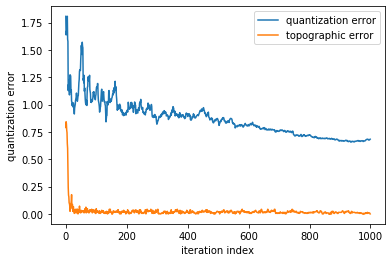

In [12]:
som = MiniSom(10, 20, data.shape[1], sigma=3., learning_rate=.7,
              neighborhood_function='gaussian', random_seed=10)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('quantization error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

Notice that in the snippet above weto run each learning iteration in a for loop and saved the errors in separated lists.